<a href="https://colab.research.google.com/github/JihyeLimm/Quest/blob/main/Going_Deeper_NLP/node3/GD_node3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3. 멋진 단어사전 만들기 [프로젝트] - SentencePiece 사용하기
1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?
>코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?
2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?
>SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.
3. SentencePiece의 성능을 다각도로 비교분석하였는가?
	>SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.


라이브러리

In [16]:
import os
import keras
import urllib.request
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.initializers import Constant
from keras.utils import pad_sequences
from keras.layers import Input, Embedding, GRU, Dense
from keras.models import Model

%matplotlib inline
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


데이터 불러오기: 네이버 영화리뷰 감정 분석 코퍼스

In [2]:
import os
from google.colab import drive
drive.mount('/gdrive', force_remount = True)
os.chdir("/gdrive/MyDrive/AIFFEL/230623")
os.getcwd()

Mounted at /gdrive


'/gdrive/MyDrive/AIFFEL/230623'

In [94]:
#데이터 불러오기
train_data = pd.read_table('/gdrive/MyDrive/AIFFEL/230522/data/ratings_train.txt')
test_data = pd.read_table('/gdrive/MyDrive/AIFFEL/230522/data/ratings_test.txt')

#data shuffle
train_data = train_data.sample(frac=1)

print(train_data.shape, test_data.shape, "\n")
train_data.head(3)

(150000, 3) (50000, 3) 



,id,document,label
20246,8703881,이게뻔한 스토리인가요? 영국마인드인지 뭔지 모르겠는데 공감도 힘들고 개연성도 도무지...,0
146993,4690458,어려운 상황에서도 최선을 다해서 노력했던 7인의 감.동.적.인 이야기,1
98119,1822317,싸구려 sf물 볼거리가 없으면 스토리라도 신경써서 만들었어야...,0


In [10]:
#학습을 위해 text저장
#NaN 결측치 제거
train_data = train_data.dropna(how = 'any')

#학습을 위해 text저장
with open("temp_output.txt", 'w', encoding = 'utf-8') as f:
  for line in train_data.document.values:
    try:
      f.write(line + '\n')
    except TypeError as TE:
      print(line, TE)

#데이터 가져오기
with open("temp_output.txt", 'r', encoding = 'utf-8') as f:
  nsmc_text = f.read().split('\n')
print(nsmc_text[0])

corpus 분석 및 전처리

In [95]:
#train_data = train_data.dropna(how = 'any')
raw = []
for sent in train_data["document"]:
  raw.append(sent)

print("Data Size:", len(raw))
print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 149995
Example:
>> 이게뻔한 스토리인가요? 영국마인드인지 뭔지 모르겠는데 공감도 힘들고 개연성도 도무지 이해가 안되네요 배경2점 배우2점
>> 정말 재밌네요 진짜 ㅋㅋㅋ흥미진진
>> 차라리 트와일라잇이 더 재밌는거같다..
>> 백성현이 최악. 그 역할도 문제고, 연기자체도 문제다. 그 인물과 사건만 들어내면 어땠을까
>> 오우~ 대단하다 나도 한때 광팬이었음~ 경빈박씨 연기 지대로다~


문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


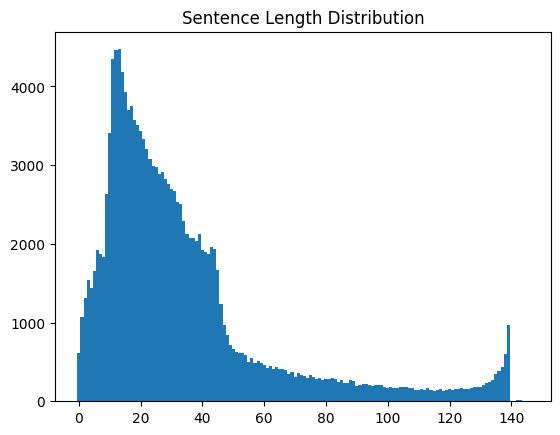

In [96]:
#최단 길이, 최장 길이, 평균 길이를 구한 후 문장 길이 분포를 막대그래프로 표현
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [ ]:
#길이가 1인 문장확인
def check_sentence_with_length(raw, length):
    count = 0

    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 1)

Data Size: 146182
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


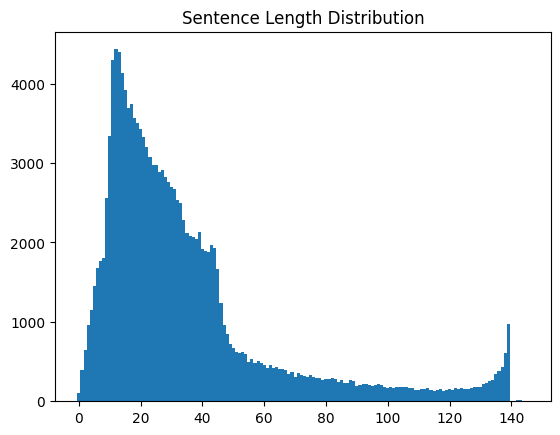

In [98]:
#중복 제거는 Python의 기본 자료형 set을 활용
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거
print("Data Size:", len(cleaned_corpus))   #Data Size: 146182

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

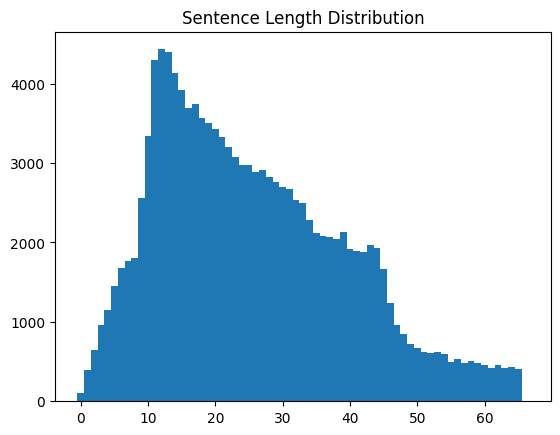

In [99]:
#가장 긴 데이터를 기준으로 Padding 처리 -> 길이 150 이상의 데이터, 길이가 10 미만인 데이터를 제거하고 사용
max_len = 67
min_len = 1

# 길이 조건에 맞는 문장만 선택
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습


In [100]:
#SentencePiece 모델을 학습import sentencepiece as spm
temp_file = "/gdrive/MyDrive/AIFFEL/230623/temp_output.txt"

vocab_size = 10000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw------- 1 root root 617980 Jun 26 07:35 korean_spm.model
-rw------- 1 root root 398238 Jun 26 07:35 korean_spm.vocab


In [114]:
#SentencePiece 모델 활용
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('여자주인공 스타일이 코트는 영아니요 여자 주윤발도이니고 ㅡ.ㅡ 차라리 가죽점퍼가더낳을듯....')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.encode_as_pieces('여자주인공 스타일이 코트는 영아니요 여자 주윤발도이니고 ㅡ.ㅡ 차라리 가죽점퍼가더낳을듯....'))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.decode_ids(tokensIDs))

[4668, 7477, 1648, 482, 268, 786, 1273, 309, 596, 4278, 267, 264, 332, 273, 1285, 260, 696, 855, 259, 266, 1009, 290, 1516, 266, 495, 8736, 1861, 298]
['▁여자주인공', '▁스타일이', '▁코', '트', '는', '▁영', '아니', '요', '▁여자', '▁주윤발', '도', '이', '니', '고', '▁ᅳ', '.', 'ᅳ', '▁차라리', '▁', '가', '죽', '점', '퍼', '가', '더', '낳', '을듯', '....']
여자주인공 스타일이 코트는 영아니요 여자 주윤발도이니고 ᅳ.ᅳ 차라리 가죽점퍼가더낳을듯....


Tokenizer 함수 작성: 학습된 모델로 sp_tokenize() 메소드 구현

In [129]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, word_index, index_word

구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습

In [132]:
#데이터 전처리 및 word_to_index 생성
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')
tokenizer = sp_tokenize(s, corpus)

def load_data(train_data, test_data, s):


  #데이터 중복제거
  train_data.drop_duplicates(subset=['document'], inplace=True)
  test_data.drop_duplicates(subset=['document'], inplace=True)

  #NaN 결측치 제거
  train_data = train_data.dropna(how = 'any')
  test_data = test_data.dropna(how = 'any')

  #토큰화
  X_train = []
  for sen in train_data['document']:
    X_train.append(sen)
  X_train, word_index, index_word = sp_tokenize(s, X_train)

  X_test = []
  for sen in test_data['document']:
    X_test.append(sen)
  X_test, bb, cc = sp_tokenize(s, X_test)

  word_to_index = word_index
  index_to_word  = index_word

  return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index, index_to_word

X_train, y_train, X_test, y_test, word_to_index, index_to_word = load_data(train_data, test_data, s)

print(len(X_train))  #146182
print(len(X_test))   #49157
print(len(index_to_word))  #10000
print(X_train[0])

146182
49157
10000
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0  367 5691  369 3081  274 2942 8219  647 2019 1969  407
  887  267 1863  273 5591 6185  980 1775  321 1717  443  290  533  443
  290]


In [133]:
#딕셔너리를 {텍스트:인덱스}구조로 변환
word_to_index = {word:index for index, word in index_to_word.items()}
print(word_to_index['나'])

288


Validation set 구성

In [134]:
#validation set 분리
x_val = X_train[:20000]
y_val = y_train[:20000]

partial_x_train = X_train[20000:]
partial_y_train = y_train[20000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(126182, 169)
(126182,)


모델구성

In [135]:
vocab_size = 10000
word_vector_dim = 100

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, word_vector_dim)(inputs)
x = layers.LSTM(128)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_14 (Embedding)    (None, None, 100)         1000000   
                                                                 
 lstm_14 (LSTM)              (None, 128)               117248    
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 dropout_26 (Dropout)        (None, 64)                0         
                                                                 
 dense_32 (Dense)            (None, 1)                 65 

In [138]:
#모델학습
callbacks = [
    keras.callbacks.EarlyStopping(monitor = "val_loss", verbose = 1, patience = 4),
    keras.callbacks.ModelCheckpoint("naver_1723.keras",
                                    save_best_only=True)
]

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks = callbacks)

#테스트셋으로 모델 평가
model = keras.models.load_model("naver_1723.keras")
print(f"테스트 accuracy: {model.evaluate(X_test, y_test)[1]:.2f}")

Epoch 1/20
1972/1972 [==============================] - 84s 31ms/step - loss: 0.4324 - accuracy: 0.8003 - val_loss: 0.3565 - val_accuracy: 0.8473
Epoch 2/20
1972/1972 [==============================] - 27s 14ms/step - loss: 0.3381 - accuracy: 0.8587 - val_loss: 0.3317 - val_accuracy: 0.8552
Epoch 3/20
1972/1972 [==============================] - 27s 14ms/step - loss: 0.3073 - accuracy: 0.8740 - val_loss: 0.3285 - val_accuracy: 0.8579
Epoch 4/20
1972/1972 [==============================] - 23s 12ms/step - loss: 0.2836 - accuracy: 0.8853 - val_loss: 0.3295 - val_accuracy: 0.8628
Epoch 5/20
1972/1972 [==============================] - 23s 12ms/step - loss: 0.2648 - accuracy: 0.8958 - val_loss: 0.3289 - val_accuracy: 0.8636
Epoch 6/20
1972/1972 [==============================] - 23s 11ms/step - loss: 0.2473 - accuracy: 0.9041 - val_loss: 0.3439 - val_accuracy: 0.8626
Epoch 7/20
1972/1972 [==============================] - 23s 12ms/step - loss: 0.2326 - accuracy: 0.9121 - val_loss: 0.3402 -

모델학습 및 그래프 시각화

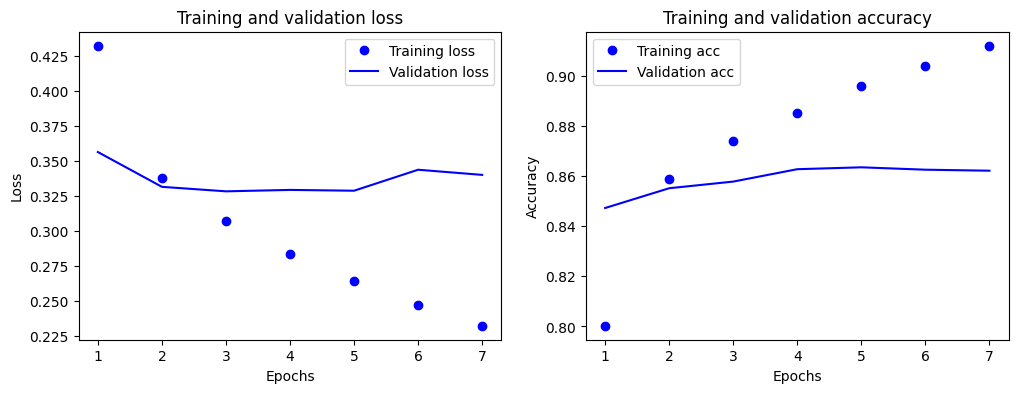

In [139]:
#history변수에 저장된 매 epoch rain/validation loss, accuracy 그래프 그리기

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,4))

#training & validation loss graph

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"입니다
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#training & validation Accuracy graph
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#KoNLPy 형태소 분석기를 사용: Mecab()

Mecab설치

In [ ]:
import os
from google.colab import drive
drive.mount('/gdrive', force_remount = True)
os.chdir("/gdrive/MyDrive/AIFFEL/230522/Mecab-ko-for-Google-Colab")
os.getcwd()

!bash install_mecab-ko_on_colab_light_220429.sh

from konlpy.tag import Mecab

mecab = Mecab()
print(mecab.morphs('자연어처리가너무재밌어서밥먹는것도가끔까먹어요'))

In [ ]:
#데이터 불러오기
train_data = pd.read_table('/gdrive/MyDrive/AIFFEL/230522/data/ratings_train.txt')
test_data = pd.read_table('/gdrive/MyDrive/AIFFEL/230522/data/ratings_test.txt')

#data shuffle
train_data = train_data.sample(frac=1)

print(train_data.shape, test_data.shape, "\n")
train_data.head(3)

데이터 전처리

In [45]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words = 10000

def load_data(train_data, test_data, num_words = num_words):
  #데이터 중복제거
  train_data.drop_duplicates(subset=['document'], inplace=True)
  test_data.drop_duplicates(subset=['document'], inplace=True)

  #NaN 결측치 제거
  train_data = train_data.dropna(how = 'any')
  test_data = test_data.dropna(how = 'any')

  #토큰화 및 불용어 제거
  X_train = []
  for sentence in train_data['document']:
    temp_X = tokenizer.morphs(sentence)   # 한국어 토크나이저로 토큰화
    temp_X = [word for word in temp_X if not word in stopwords]  # 불용어(Stopwords) 제거
    X_train.append(temp_X)

  X_test = []
  for sentence in test_data['document']:
    temp_X = tokenizer.morphs(sentence)   # 한국어 토크나이저로 토큰화
    temp_X = [word for word in temp_X if not word in stopwords]  # 불용어(Stopwords) 제거
    X_test.append(temp_X)

  words = np.concatenate(X_train).tolist()
  counter = Counter(words)
  counter = counter.most_common(num_words-4)
  vocab = ['', '', '', ''] + [key for key, _ in counter]
  word_to_index = {word:index for index, word in enumerate(vocab)}

  #사전word_to_index 구성
  def wordlist_to_indexlist(wordlist):
      return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

  X_train = list(map(wordlist_to_indexlist, X_train))
  X_test = list(map(wordlist_to_indexlist, X_test))

  return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

10000
2
(146182, 67)
(49157, 67)


In [ ]:
#index_to_word생성
index_to_word = {index:word for word, index in word_to_index.items()}

#", , "는 관례적으로 딕셔너리 맨 앞에 넣어줌
index_to_word[0]=""  # 패딩용 단어
index_to_word[1]=""  # 문장의 시작지점
index_to_word[2]=""  # 사전에 없는(Unknown) 단어


#딕셔너리를 {텍스트:인덱스}구조로 변환
word_to_index = {word:index for index, word in index_to_word.items()}


#패딩 추가
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index[""],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=67)  ##적절한 최대 문장 길이(maxlen) 지정: (평균 + 4*표준편차)로 가정 => 67

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index[""],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=67)

print(x_train.shape)  #(146182, 67)
print(x_test.shape)   #(49157, 67)

In [46]:
#validation set 분리

import random
x_val = x_train[:20000]
y_val = y_train[:20000]

partial_x_train = x_train[20000:]
partial_y_train = y_train[20000:]

모델 선언 및 학습

In [61]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

vocab_size = 8000
word_vector_dim = 100

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, word_vector_dim)(inputs)
x = layers.LSTM(128)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

#모델학습
callbacks = [
    keras.callbacks.EarlyStopping(monitor = "val_loss", verbose = 1, patience = 4),
    keras.callbacks.ModelCheckpoint("naver_1507.keras",
                                    save_best_only=True)
]

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks = callbacks)

#테스트셋으로 모델 평가
model = keras.models.load_model("naver_1507.keras")
print(f"테스트 accuracy: {model.evaluate(x_test, y_test)[1]:.2f}")

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_11 (Embedding)    (None, None, 100)         800000    
                                                                 
 lstm_11 (LSTM)              (None, 128)               117248    
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_35 (Dense)            (None, 1)                 65 

그래프 확인

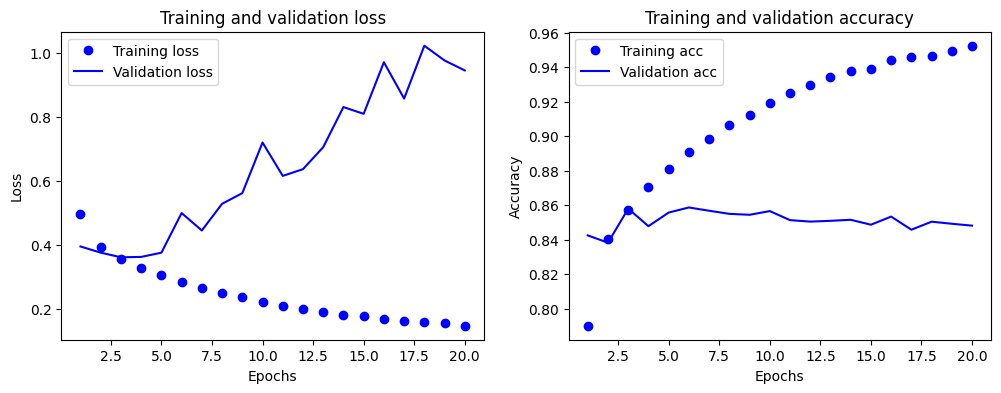

In [56]:
#history변수에 저장된 매 epoch rain/validation loss, accuracy 그래프 그리기

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,4))

#training & validation loss graph

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"입니다
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#training & validation Accuracy graph
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()